In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
import pickle
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
nTurn = 1024

nCore_y = 8
nCore_z = 4

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8
dTune = 0.0

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

# 1. Preparation

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu
lattice[1].pipe_radius = 0.02*np.sqrt(2)

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

In [6]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 1000
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
npt = len(pTest)
beam.n_particles = npt
print('initial npt=',npt)

initial npt= 783764


In [7]:
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

In [8]:
lattice[0].turns = nTurn

TBT = impact.getElem('TBT')
TBT.file_id = nTurn
TBT.pID_begin = 1
TBT.pID_end = npt
lattice.insert(1,TBT)

In [9]:
impact.writeInputFile(beam,lattice) 
# impact.run(beam)

In [ ]:
iTBT,TBT = impact.readTBT(nTurn,ke,mass,freq)
npt = len(iTBT)
print(npt)

In [ ]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [ ]:
def isClose2resonant(nu0,nu1):
    for i in range(1,4):
        test = np.mod(nu0*i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
#         test = np.mod(nu0/i,1)
#         if test*0.997 < nu1 < test*1.003:
#             return True
    for i in range(-3,0):
        test = np.mod(nu0*i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
#         test = np.mod(nu0/i,1)
#         if test*0.997 < nu1 < test*1.003:
#             return True
    return False

def pick_non_resonant_tune(nu0,tunes):
    for i in range(len(tunes)):
        if not isClose2resonant(nu0,tunes[i]):
            return(tunes[i])
    return tunes[0]

In [ ]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
tuneYnoR = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tunes = impact.util.naff(16,signal,window_id=1)[0]
    tuneY[i] = tunes[0]
    tuneYnoR[i] = pick_non_resonant_tune(tuneX[i],tunes)

In [10]:
# data = {'X0':np.real(X[0,:]),'Y0':np.real(Y[0,:]),'nu_x':tuneX,'nu_y':tuneY,'nu_y_noR':tuneYnoR}
# with open('tuneContourData','wb') as f:
#     pickle.dump(data,f)

In [60]:
with open('tuneContourData','rb') as f:
    data = pickle.load(f)

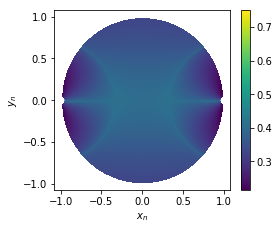

In [12]:
xmax = np.max([data['X0'],data['Y0']])
plt.figure(figsize=[4,3.3])
f1=plt.scatter(data['X0'],data['Y0'],c=data['nu_x'],s=0.16,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA.tune.nux.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)

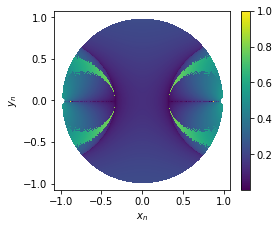

In [13]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(data['X0'],data['Y0'],c=data['nu_y'],s=0.16,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA.tune.nuy.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)

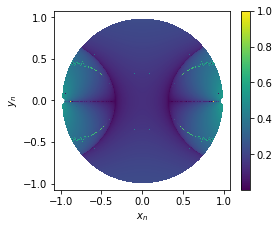

In [14]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(data['X0'],data['Y0'],c=data['nu_y_noR'],s=0.16,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA.tune.nuy_noR.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)

In [15]:
class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s

In [16]:
data['Y0'].shape

(782364,)

##### resonance
 - $n \nu_x + m \nu_y = k$  
 
  - $n (a_1\nu_1 + a_2\nu_2) + m (b_1\nu_1 + b_2\nu_2) = k$  
 
    - $(n a_1 + m b_1)\nu_1 + (n a_2 + m b_2)\nu_2 = k$  
 
 - $\frac{\nu_y}{\nu_x} = -\frac{n}{m} + \frac{k}{m \nu_x}$

In [ ]:
K = np.arange(-4,5)
N = [1,2,3,4]
M = [-4,-3,-2,-1,1,2,3,4]
for n in N:
    for m in M:
        try:
            plt.figure(figsize=[8,6.6])
            f1=plt.tricontour(data['X0'],data['Y0'],n*data['nu_x']+m*data['nu_y'],
                              levels = K,
                              cmap = 'nipy_spectral')
            plt.xlim(-xmax*1.1,xmax*1.1)
            plt.ylim(-xmax*1.1,xmax*1.1)
            plt.xlabel('$x_n$')
            plt.ylabel('$y_n$')
            plt.colorbar(f1)
            f1.levels = [nf(val) for val in f1.levels]
            plt.clabel(f1, f1.levels, fontsize=10)
            plt.tight_layout()
            title = 'DA.contour.'+str(n)+'nux'
            if m<0:
                title = title + str(m)
            else:
                title = title + '+' + str(m)
            title = title + 'nuy.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png'
            plt.savefig(title,dpi=180)
        except:
            tmp = n*data['nu_x']+m*data['nu_y']
            print('n,m,min,max=',n,m,tmp.min(),tmp.max())

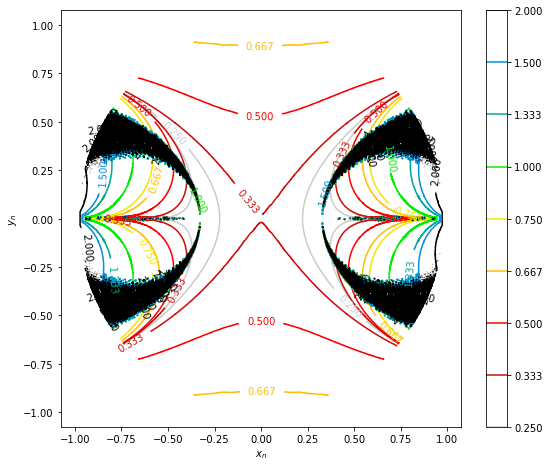

In [58]:
levels = []
for i in range(1,5):
    for j in range(1,5):
        if(i/j) <=2:
            levels.append(i/j)
levels = np.array(levels)
levels = np.unique(levels)
plt.figure(figsize=[8,6.6])
f1=plt.tricontour(data['X0'],data['Y0'],data['nu_y']/data['nu_x'], 
                  levels=levels,
                  cmap = 'nipy_spectral_r')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
f1.levels = [nf(val) for val in f1.levels]
plt.clabel(f1, f1.levels, fontsize=10)
plt.tight_layout()
plt.savefig('DA.contour.nuy_nux.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)

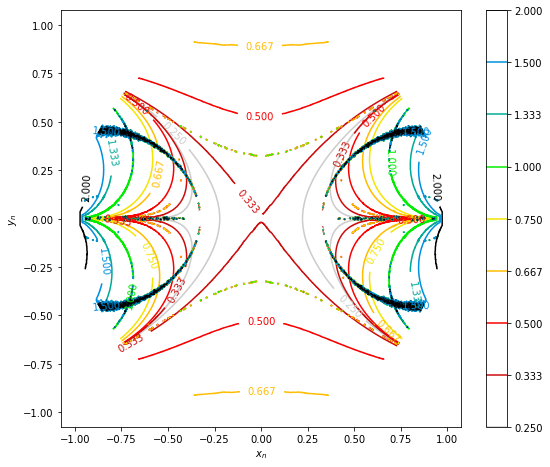

In [59]:
levels = np.unique(levels)
plt.figure(figsize=[8,6.6])
f1=plt.tricontour(data['X0'],data['Y0'],data['nu_y_noR']/data['nu_x'], 
                  levels=levels,
                  cmap = 'nipy_spectral_r')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
f1.levels = [nf(val) for val in f1.levels]
plt.clabel(f1, f1.levels, fontsize=10)
plt.tight_layout()
plt.savefig('DA.contour.nuyNoR_nux.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)

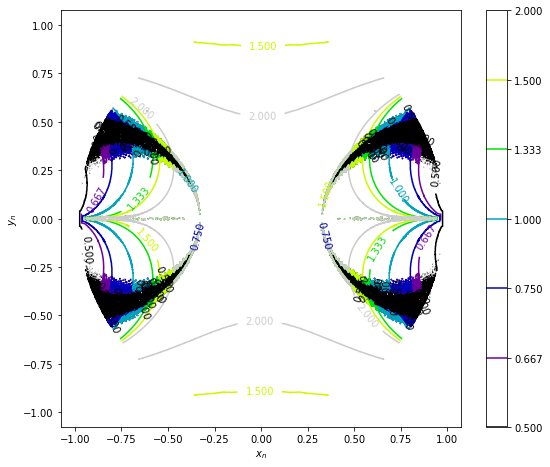

In [57]:
plt.figure(figsize=[8,6.6])
f1=plt.tricontour(data['X0'],data['Y0'],data['nu_x']/data['nu_y'], 
                  levels=levels,
                  cmap = 'nipy_spectral')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
f1.levels = [nf(val) for val in f1.levels]
plt.clabel(f1, f1.levels, fontsize=10)
plt.tight_layout()
plt.savefig('DA.contour.nux_nuy.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)

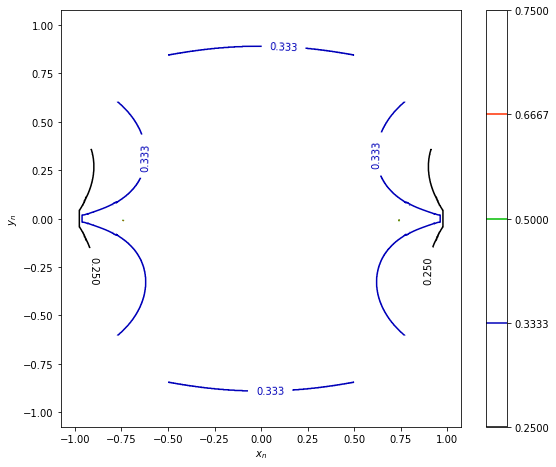

In [46]:
plt.figure(figsize=[8,6.6])
f1=plt.tricontour(data['X0'],data['Y0'],data['nu_x'], 
                  levels=levels,
                  cmap = 'nipy_spectral')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
f1.levels = [nf(val) for val in f1.levels]
plt.clabel(f1, f1.levels, fontsize=10)
plt.tight_layout()
plt.savefig('DA.contour.nux.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)

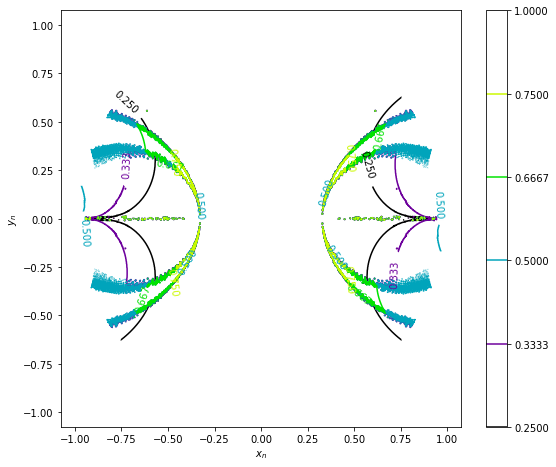

In [47]:
plt.figure(figsize=[8,6.6])
f1=plt.tricontour(data['X0'],data['Y0'],data['nu_y'],
                  levels=levels,
                  cmap = 'nipy_spectral')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
f1.levels = [nf(val) for val in f1.levels]
plt.clabel(f1, f1.levels, fontsize=10)
plt.tight_layout()
plt.savefig('DA.contour.nuy.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.turn='+str(nTurn)+'.png',dpi=180)